In [86]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print(tf.__version__)
print(np.__version__)
print(matplotlib.__version__)

2.6.0
1.21.4
3.4.3


## 실험 개요
Baseline:
1. 한국어와 영어 tokenizer 모두 SentencePiece로 사용
2. Lexical Substitution 미사용

실험 1:
1. 한국어는 Mecab, 영어는 SentencePiece tokenizer 사용
2. Lexical Substitution 미사용

실험 2:
1. 한국어는 Mecab, 영어는 SentencePiece tokenizer 사용
2. Lexical Substitution 사용

# Baseline

In [87]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [88]:
cleaned_corpus[0]

('파키스탄 라왈핀디에서 27일(현지시간) 선거유세 후 암살된 베나지르 부토 전 총리는 파키스탄을 비롯해 이슬람 국가 사상 첫 여성 총리였다.',
 'Benazir Bhutto, who was assassinated Thursday in Rawalpindi, was the first female prime minister of Pakistan and of any Islamic nation.')

In [89]:
len(cleaned_corpus)

78968

In [90]:
def preprocess_sentence(sentence):
    # 1. 모든 입력을 소문자로 변환
    sentence = sentence.lower()

    # 2. 알파벳, 문장부호, 한글, 숫자만 남기고 모두 제거
    #    허용되지 않는 문자는 공백으로 치환하여 단어가 붙는 것을 방지
    sentence = re.sub(r"[^a-zㄱ-ㅎㅏ-ㅣ가-힣0-9.?!,']", " ", sentence)

    # 3. 문장부호 양옆에 공백을 추가
    #    처리할 문장부호: . ? ! , '
    sentence = re.sub(r"([?.!,'])", r" \1 ", sentence) 
    
    # 4. 문장 앞뒤의 불필요한 공백을 제거하고, 여러 공백을 단일 공백으로 만듦
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    
    return sentence

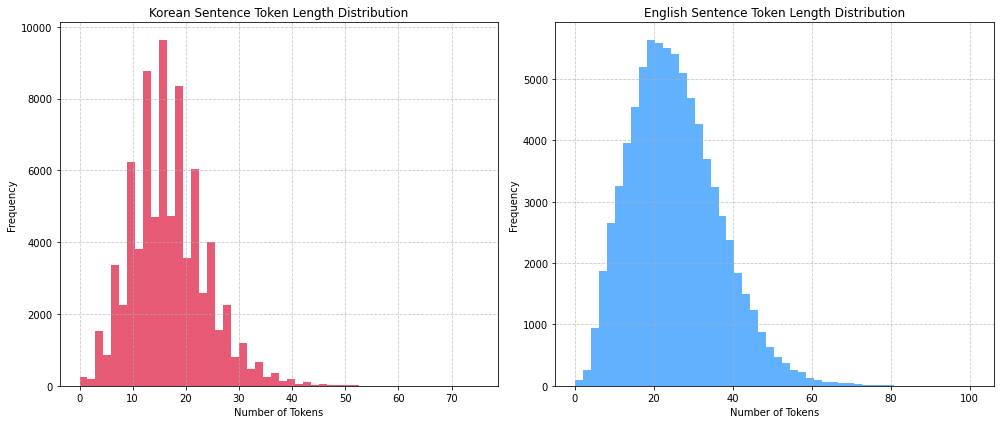

In [91]:
# 1. 각 문장에 대해 preprocess_sentence를 적용합니다.
processed_kor_sentences = [preprocess_sentence(s[0]) for s in cleaned_corpus]
processed_eng_sentences = [preprocess_sentence(s[1]) for s in cleaned_corpus]

# 2. 전처리된 문장의 토큰 길이를 계산합니다.
#    문장이 비어있으면 길이 0, 그렇지 않으면 공백으로 나눈 토큰의 수.
kor_lengths = [len(s.split()) if s else 0 for s in processed_kor_sentences]
eng_lengths = [len(s.split()) if s else 0 for s in processed_eng_sentences]

# 3. 시각화
plt.figure(figsize=(14, 6))

# 한국어 문장 길이 분포
plt.subplot(1, 2, 1)
plt.hist(kor_lengths, bins=50, color='crimson', alpha=0.7)
plt.title('Korean Sentence Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)

# 영어 문장 길이 분포
plt.subplot(1, 2, 2)
plt.hist(eng_lengths, bins=50, color='dodgerblue', alpha=0.7)
plt.title('English Sentence Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # 그래프들이 겹치지 않도록 조정
plt.show()

- 토큰화 후 길이가 40을 넘어가는 샘플 개수는 한국어보다 영어가 눈에 띄게 많다.

In [92]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):

    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w') as f:
        for row in corpus: f.write(str(row) + '\n')

    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        input=file,
        model_prefix=model,
        vocab_size=vocab_size,
        pad_id=pad_id,
        bos_id=bos_id,
        eos_id=eos_id,
        unk_id=unk_id,
        model_type='unigram'
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer

In [93]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

kor_corpus_train, kor_corpus_test, eng_corpus_train, eng_corpus_test = train_test_split(
    kor_corpus,    # 전체 전처리된 한국어 문장 (문자열) 리스트
    eng_corpus,    # 전체 전처리된 영어 문장 (문자열) 리스트
    test_size=0.2,
    random_state=42
)

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, lang="ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, lang="en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./ko_corpus.txt
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_

True

ization_rule_tsv: 
}
denormalizer_spec {}
trainer_interface.cc(329) LOG(INFO) SentenceIterator is not specified. Using MultiFileSentenceIterator.
trainer_interface.cc(178) LOG(INFO) Loading corpus: ./en_corpus.txt
trainer_interface.cc(385) LOG(INFO) Loaded all 78957 sentences
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <pad>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: </s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <unk>
trainer_interface.cc(405) LOG(INFO) Normalizing sentences...
trainer_interface.cc(466) LOG(INFO) all chars count=10841208
trainer_interface.cc(477) LOG(INFO) Done: 99.9508% characters are covered.
trainer_interface.cc(487) LOG(INFO) Alphabet size=39
trainer_interface.cc(488) LOG(INFO) Final character coverage=0.999508
trainer_interface.cc(520) LOG(INFO) Done! preprocessed 78957 sentences.
unigram_model_trainer.cc(139) LOG(INFO) Making suffix array...
unigram_model_trainer.cc(14

In [94]:
print(kor_corpus[0])
print(eng_corpus[0])

파키스탄 라왈핀디에서 27일 현지시간 선거유세 후 암살된 베나지르 부토 전 총리는 파키스탄을 비롯해 이슬람 국가 사상 첫 여성 총리였다 .
benazir bhutto , who was assassinated thursday in rawalpindi , was the first female prime minister of pakistan and of any islamic nation .


In [95]:
print(kor_corpus_train[100])
print(eng_corpus_train[100])

한국과 미국 실무자들은 c4i 군사 지휘 시스템을 이전하는 비용에 대해서 논의했는데 , c4i란 지휘 , 통제 , 통신 , 컴퓨터 , 정보 시스템을 뜻한다 .
south korean and u . s . working level officials have discussed the cost of moving the c4i military command system , which stands for a joint command , control , communications , computers and intelligence system .


In [96]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus_train) == len(eng_corpus_train)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
MAX_LEN = 50
for idx in tqdm(range(len(kor_corpus_train))):
    if (len(kor_corpus_train[idx]) <= MAX_LEN and len(eng_corpus_train[idx]) <= MAX_LEN):
        src_corpus.append(ko_tokenizer.encode_as_ids(kor_corpus_train[idx]))
        tgt_corpus.append(en_tokenizer.encode_as_ids(eng_corpus_train[idx]))
    

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/63174 [00:00<?, ?it/s]

- src_corpus에는 토큰 길이 50 이하의 한국어 문장이 토큰화된 후 저장돼 있음.
    - src_corpus[0]
    > [[1770, 330, 15260, 8, 726, 224, 4], ...]
- tgt_corpus에는 토큰 길이 50 이하의 영어 문장이 토큰화된 후 저장돼 있음.
    - tgt_corpus[0]
    > [[1, 81, 106, 108, 188, 29, 27, 284, 7440, 6487, 73, 15905, 5, 2], ...]


- enc_train은 src_corpus(토큰화된 한국어 텍스트)를 패딩 처리한 벡터들의 리스트
    - enc_train[0]
    > array([ 1770,   330, 15260,     8,   726,   224,     4,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0], dtype=int32)

- dec_train은 tgt_corpus(토큰화된 영어 텍스트)를 패딩 처리한 벡터들의 리스트
    - dec_train[0]
    > array([    1,    81,   106,   108,   188,    29,    27,   284,  7440,
        6487,    73, 15905,     5,     2,     0,     0,     0,     0,
           0], dtype=int32)

## 1. Transformer 모델 설계

In [97]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [98]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [99]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [100]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out


In [101]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [102]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [103]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [104]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [105]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns


## 2. Transformer 모델 훈련

In [106]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)
		
d_model = 512


In [107]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [108]:
learning_rate = LearningRateScheduler(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [109]:
# Loss function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [110]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    return loss, enc_attns, dec_attns, dec_enc_attns

## 모델 학습

In [111]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    layer = 2
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    print("Encoder Layer", layer)
    for h in range(4):
        draw(enc_attns[layer-1][0, h, :len(src), :len(src)], axs[h], src, src)
    plt.show()
        
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    print("Decoder Self Layer", layer)
    for h in range(4):
        draw(dec_attns[layer-1][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
    plt.show()

    print("Decoder Src Layer", layer)
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    for h in range(4):
        draw(dec_enc_attns[layer-1][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
    plt.show()

In [112]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [113]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)
    return result

In [114]:
from tqdm import tqdm_notebook 
import random

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_62/99984386.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the .
Input: 시민들은 도시 속에 산다.
Predicted translation: the .
Input: 커피는 필요 없다.
Predicted translation: the .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the the the the .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the .
Input: 커피는 필요 없다.
Predicted translation: the the the .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the the the the the .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the was is aed .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the a is .
Input: 커피는 필요 없다.
Predicted translation: the ' s is a .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the the was .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the is a is aed .
Input: 시민들은 도시 속에 산다.
Predicted translation: the the is the the the the the the the .
Input: 커피는 필요 없다.
Predicted translation: the was is a was .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the was is the the the the the the the the .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: i ' s a on the on the
Input: 시민들은 도시 속에 산다.
Predicted translation: the dow is a the the the the the the the .
Input: 커피는 필요 없다.
Predicted translation: it ' s a a a a .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dow is a the dow .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he ' s a new on to be .
Input: 시민들은 도시 속에 산다.
Predicted translation: the dow is a  ⁇ 
Input: 커피는 필요 없다.
Predicted translation: he ' s a an to be in the
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dow is at .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama ' s a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the first is a lot .
Input: 커피는 필요 없다.
Predicted translation: he ' s a all to be in a  ⁇ 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the first was a newt .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama ' s obama to president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the dow is a lot to the message .
Input: 커피는 필요 없다.
Predicted translation: he ' s a u .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the first was the firstt .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama ' s president to president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the president is a president .
Input: 커피는 필요 없다.
Predicted translation: he ' s to take to take to take to take .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the first was at the first of the world .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama ' s president president down .
Input: 시민들은 도시 속에 산다.
Predicted translation: the president is a  ⁇ 
Input: 커피는 필요 없다.
Predicted translation: he ' s take an u .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the first korea at the firstt .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama ' s obama ' s president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the president is expected .
Input: 커피는 필요 없다.
Predicted translation: he ' s to being to being to hand .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least the first korea at a minute .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama ' s work with afghanistan .
Input: 시민들은 도시 속에 산다.
Predicted translation: the president is a  ⁇ 
Input: 커피는 필요 없다.
Predicted translation: it ' s take an family to hand to hand .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the first decision are also deaths .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama ' s president s president with president .
Input: 시민들은 도시 속에 산다.
Predicted translation: their harry is a key to threely .
Input: 커피는 필요 없다.
Predicted translation: i ' s address to find to find to hand .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least those decision at the decision .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama ' s president president president with chief ' s .
Input: 시민들은 도시 속에 산다.
Predicted translation: the mosts their year .
Input: 커피는 필요 없다.
Predicted translation: i ' s mark smith to find that .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at the main korea was at least .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama ' s president president president president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the party is a president  ⁇ 
Input: 커피는 필요 없다.
Predicted translation: if ' s mark smith , he ' s a hand to hand .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at the firstt end at a world .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama ' s president to president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the most will go is down  ⁇ 
Input: 커피는 필요 없다.
Predicted translation: he ' s mark smith to speak .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at the firsties are oneies .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he ' s president down president .
Input: 시민들은 도시 속에 산다.
Predicted translation: known to go to go to nearly 6 .
Input: 커피는 필요 없다.
Predicted translation: he ' s mark smith for a mother to harm .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: there are helped at least at least .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama ' s president with president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the b is expected to three related .
Input: 커피는 필요 없다.
Predicted translation: it is live to do a day .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at the first died at least .


  0%|          | 0/61 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama ' s president to president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the year is to go a keying .
Input: 커피는 필요 없다.
Predicted translation: he ' s mark smith to speak .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at the korea was shot a korea .


In [115]:
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    src_tokens = src_tokenizer.encode_as_ids(src_sentence)
    tgt_tokens = tgt_tokenizer.encode_as_ids(tgt_sentence)

    if (len(src_tokens) > MAX_LEN): return None
    if (len(tgt_tokens) > MAX_LEN): return None

    reference = tgt_sentence.split()
    candidate = translate(src_tokens, model, src_tokenizer, tgt_tokenizer).split()

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score

def eval_bleu(model, src_sentences, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], src_tokenizer, tgt_tokenizer, verbose)
        if not score: continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)

In [116]:
eval_bleu(transformer, kor_corpus_test, eng_corpus_test, ko_tokenizer, en_tokenizer)

  0%|          | 0/15794 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'lower'

- Baseline 모델의 번역 결과는 실망스러움.
    - 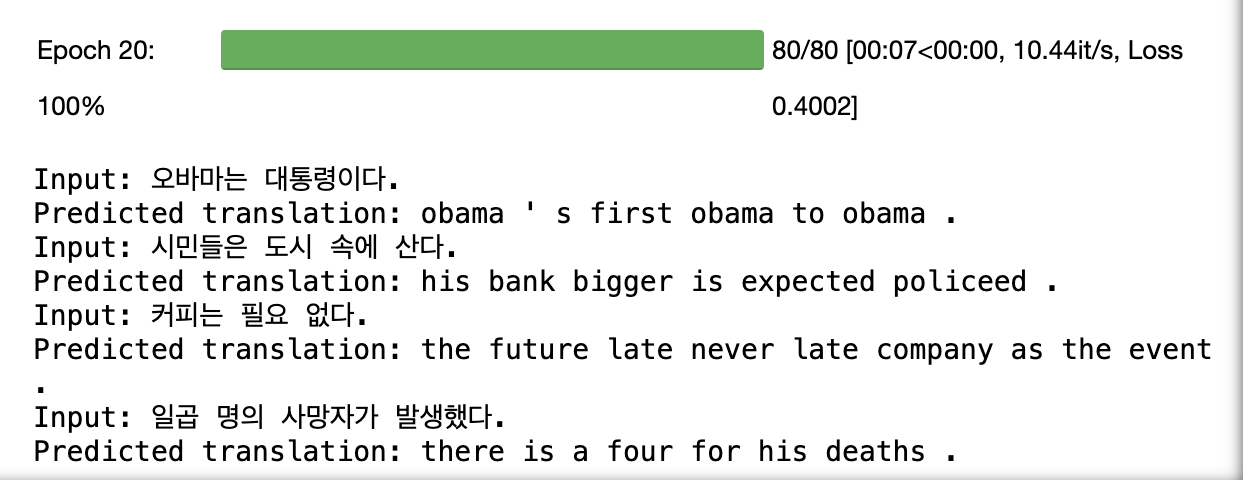
- 전처리 시 실수로 숫자를 안 남기고 제거해버렸는데, 이 때문에 ordinal 숫자와 cardinal 숫자의 연관성을 학습하지 못했을 수도 있겠다.
- 개선할 지점:
    - 한국어 전용 토크나이저(Mecab) 사용
    - Lexical substitution으로 데이터 증강

# 실험 1
한국어는 Mecab, 영어는 SentencePiece로 토큰화

In [31]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [32]:
cleaned_corpus[0]

('파키스탄 라왈핀디에서 27일(현지시간) 선거유세 후 암살된 베나지르 부토 전 총리는 파키스탄을 비롯해 이슬람 국가 사상 첫 여성 총리였다.',
 'Benazir Bhutto, who was assassinated Thursday in Rawalpindi, was the first female prime minister of Pakistan and of any Islamic nation.')

In [33]:
def preprocess_sentence(sentence):
    # 1. 모든 입력을 소문자로 변환
    sentence = sentence.lower()

    # 2. 알파벳, 문장부호, 한글, 숫자만 남기고 모두 제거
    #    허용되지 않는 문자는 공백으로 치환하여 단어가 붙는 것을 방지
    sentence = re.sub(r"[^a-zㄱ-ㅎㅏ-ㅣ가-힣0-9.?!,']", " ", sentence) # 위에서 포함하지 않았던 숫자도 포함해줌

    # 3. 문장부호 양옆에 공백을 추가
    #    처리할 문장부호: . ? ! , '
    sentence = re.sub(r"([?.!,'])", r" \1 ", sentence) 
    
    # 4. 문장 앞뒤의 불필요한 공백을 제거하고, 여러 공백을 단일 공백으로 만듦
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    
    return sentence

In [34]:
from konlpy.tag import Mecab
mecab = Mecab()

In [35]:
mecab.morphs("오바마는 대통령이다.")

['오바마', '는', '대통령', '이', '다', '.']

In [36]:
kor_corpus_exp1 = []
eng_corpus_exp1 = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]

    kor_corpus_exp1.append(preprocess_sentence(k))
    eng_corpus_exp1.append(preprocess_sentence(e))

In [37]:
en_tokenizer_exp1 = generate_tokenizer(eng_corpus_exp1, TGT_VOCAB_SIZE, lang="en_exp1")
en_tokenizer_exp1.set_encode_extra_options("bos:eos")  # BOS/EOS 토큰 자동 추가
print(f"English vocab size: {en_tokenizer_exp1.get_piece_size()}")

English vocab size: 20000


sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./en_exp1_corpus.txt
  input_format: 
  model_prefix: en_exp1_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1

In [42]:
# Mecab을 이용한 한국어 tokenizer 생성
class KerasMecabTokenizerWrapper:
    def __init__(self, keras_tokenizer, mecab_tokenizer):
        self.keras_tokenizer = keras_tokenizer
        self.mecab_tokenizer = mecab_tokenizer
        # Keras Tokenizer는 pad_sequences에서 0을 패딩 ID로 사용합니다.
        # SentencePiece 학습 시 pad_id=0 으로 설정한 것과 일관성을 가집니다.

    def encode_as_ids(self, sentence_str):
        tokens = self.mecab_tokenizer.morphs(sentence_str)
        # texts_to_sequences는 리스트의 리스트를 반환하므로 첫 번째 원소를 가져옵니다.
        sequence = self.keras_tokenizer.texts_to_sequences([tokens])[0]
        return sequence
    
    def encode_as_pieces(self, sentence_str):
        # evaluate 함수 내에서 preprocess_sentence가 이미 호출되므로,
        # 여기서는 mecab.morphs()만 사용하여 토큰 조각을 반환합니다.
        return self.mecab_tokenizer.morphs(sentence_str)

    def decode_ids(self, ids):
        # sequences_to_texts는 리스트의 리스트를 반환하므로 첫 번째 원소를 가져옵니다.
        return self.keras_tokenizer.sequences_to_texts([ids])[0]

    def pad_id(self):
        return 0 # Keras Tokenizer 사용 시 관례적으로 0

    def vocab_size(self):
        # num_words를 고려하여 실제 사용될 어휘 크기를 반환합니다.
        # +1은 패딩(0)과 OOV 토큰을 고려한 크기입니다.
        return self.keras_tokenizer.num_words if self.keras_tokenizer.num_words is not None else len(self.keras_tokenizer.word_index) + 1
    


kor_corpus_mecab_tokenized = [mecab.morphs(sentence) for sentence in kor_corpus_exp1]
ko_tokenizer_keras = tf.keras.preprocessing.text.Tokenizer(
    num_words=SRC_VOCAB_SIZE, # 가장 빈도가 높은 단어부터 SRC_VOCAB_SIZE 개수만큼 사용
    oov_token="<unk>"         # Out-of-vocabulary 토큰 정의
)
ko_tokenizer_keras.fit_on_texts(kor_corpus_mecab_tokenized)

# 래퍼 클래스를 사용하여 ko_tokenizer_exp1 생성
ko_tokenizer_exp1 = KerasMecabTokenizerWrapper(ko_tokenizer_keras, mecab)


print(f"Korean vocab size: {ko_tokenizer_exp1.vocab_size()}")


Korean vocab size: 20000


- ko_tokenizer_exp1, en_tokenizer_exp1 각각 생성함. 이후의 과정은 Baseline에서와 같음.

In [43]:
src_corpus_exp1 = []
tgt_corpus_exp1 = []

assert len(kor_corpus_exp1) == len(eng_corpus_exp1)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
MAX_LEN = 50
for idx in tqdm(range(len(kor_corpus_exp1))):
    if (len(kor_corpus_exp1[idx]) <= MAX_LEN and len(eng_corpus_exp1[idx]) <= MAX_LEN):
        src_corpus_exp1.append(ko_tokenizer_exp1.encode_as_ids(kor_corpus_exp1[idx]))
        tgt_corpus_exp1.append(en_tokenizer_exp1.encode_as_ids(eng_corpus_exp1[idx]))
    

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train_exp1 = tf.keras.preprocessing.sequence.pad_sequences(src_corpus_exp1, padding='post')
dec_train_exp1 = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus_exp1, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [44]:
print("Tokenized sequence: ", src_corpus_exp1[0])
print("Padded Tokenized sequence: ", enc_train_exp1[0])

Tokenized sequence:  [1296, 169, 7, 19, 1009, 99, 58, 3772, 2]
Padded Tokenized sequence:  [1296  169    7   19 1009   99   58 3772    2    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [45]:
for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train_exp1.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train_exp1[idx:idx+BATCH_SIZE],
                    dec_train_exp1[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer_exp1, en_tokenizer_exp1)

/tmp/ipykernel_62/4260974941.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama ' s a lot of obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the new yorked in new cut .
Input: 커피는 필요 없다.
Predicted translation: we ' t know to the world ' t ' t .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the cause of the attack was killed .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is obama to obamac obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the dow is off , the couples .
Input: 커피는 필요 없다.
Predicted translation: it ' s reallyvery like to see .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: three of the victims were injured .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama poised to obamac obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the new names of such expertss are  ⁇ 
Input: 커피는 필요 없다.
Predicted translation: we ' t want to see it ' t my necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: three of five 42 deaths are to early .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama would obama ' s mission .
Input: 시민들은 도시 속에 산다.
Predicted translation: the degrees are such .
Input: 커피는 필요 없다.
Predicted translation: we ' don ' t think .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: three of the wounded have been killed .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama to being obama to win .
Input: 시민들은 도시 속에 산다.
Predicted translation: the new media won him .
Input: 커피는 필요 없다.
Predicted translation: i ' m not just like to happen .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: three of five other people were wounded .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama would obama ' s obamaing obama obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: keeping new zealand .
Input: 커피는 필요 없다.
Predicted translation: it is not to speak .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a person of  ⁇ 5 were also5 .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama would obama obama obama obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: some faces to the new zealand .
Input: 커피는 필요 없다.
Predicted translation: it ' s not the way .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: three of the victims were killed .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama calls obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: some experts denied , an hour in gaza .
Input: 커피는 필요 없다.
Predicted translation: there is to speak .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death toll is the news before the at 8 .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is off obama , mccain is obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the name of the cuts are also be .
Input: 커피는 필요 없다.
Predicted translation: we need to the hard is my .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least national have been killed .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama dreams obamac obamac today .
Input: 시민들은 도시 속에 산다.
Predicted translation: but you thinks to be denied .
Input: 커피는 필요 없다.
Predicted translation: we need to apologize for no .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death toll was closeed to the at 16 .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is denied obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: some young , such in new zealand .
Input: 커피는 필요 없다.
Predicted translation: there ' s no answer it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death toll was three children


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama calls a obamac texas .
Input: 시민들은 도시 속에 산다.
Predicted translation: some young , do you slipped to about  ⁇  .
Input: 커피는 필요 없다.
Predicted translation: we need to speak , she said .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: deaths women three died .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama calls the united obama on monday .
Input: 시민들은 도시 속에 산다.
Predicted translation: somements are responsibility in apriing .
Input: 커피는 필요 없다.
Predicted translation: it ' s not clear when we need to happen .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: an in april votes .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama denied obama on obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the bank of fire un idea .
Input: 커피는 필요 없다.
Predicted translation: it ' s not to keep deep in her .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: another were reported .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama ' s mo bigger
Input: 시민들은 도시 속에 산다.
Predicted translation: some sends are  ⁇ 9 .
Input: 커피는 필요 없다.
Predicted translation: it is not very welly .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at a member of the crash claimed at one .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama denied obama on obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: some singaporeans are taken in off workers a long .
Input: 커피는 필요 없다.
Predicted translation: it ' s not a yes of any office .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: one of a surpriset got civilians .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama ' s accused obama to being obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: some take people late
Input: 커피는 필요 없다.
Predicted translation: it is not sold to the general public .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: he was killed in her death .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama denied accusing obama
Input: 시민들은 도시 속에 산다.
Predicted translation: some do it wasn ' t see to be their important .
Input: 커피는 필요 없다.
Predicted translation: it is not clear when you like she has not a difficult .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: there were injured in the crash .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama to roll obama to 15 obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: wall street , the dow is up 45 .
Input: 커피는 필요 없다.
Predicted translation: how did you doesn ' t supposed to between .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: death toll said she have been were three .


  0%|          | 0/77 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama wins to obama to obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: some take cat interpret rights .
Input: 커피는 필요 없다.
Predicted translation: it is nothing to speak today .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 1 killed at a similar .
